<a href="https://colab.research.google.com/github/eccho03/datamining_project_clothes/blob/main/A_priori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [16]:
# CSV 파일 읽기
data = pd.read_csv('https://raw.githubusercontent.com/eccho03/datamining_project_clothes/refs/heads/main/size_selection_info.csv')

# 데이터 확인
print(data.head())

   weight   age  height size
0      62  28.0  172.72   XL
1      59  36.0  167.64    L
2      61  34.0  165.10    M
3      65  27.0  175.26    L
4      62  45.0  172.72    M


In [17]:
num_columns = ['weight', 'age', 'height']
mean = data[num_columns].mean()
std = data[num_columns].std()

# 결과 출력
print("평균")
print(mean)
print("\n표준편차")
print(std)

# 'size'의 범주별 빈도 확인
print("\nSize 빈도수")
print(data['size'].value_counts())

# 전체 데이터 요약 정보
print("\n데이터 요약 정보")
print(data.info())

평균
weight     61.756811
age        34.027311
height    165.805794
dtype: float64

표준편차
weight    9.944863
age       8.149447
height    6.737651
dtype: float64

Size 빈도수
size
M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
Name: count, dtype: int64

데이터 요약 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119734 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119734 non-null  int64  
 1   age     119477 non-null  float64
 2   height  119404 non-null  float64
 3   size    119734 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB
None


In [18]:
# 키와 몸무게를 숫자형으로 변환
data['height'] = pd.to_numeric(data['height'], errors='coerce')
data['weight'] = pd.to_numeric(data['weight'], errors='coerce')

# 결측값 제거
data.dropna(subset=['height', 'weight'], inplace=True)

In [19]:
# 키 범주화
bins_height = [0, 150, 155, 160, 165, 170, 175, 180, float('inf')]
labels_height = ['less_150cm', '151~154cm', '155~159cm', '160~164cm', '165~169cm', '170~174cm', '175~179cm', 'over_180cm']
data['height_range'] = pd.cut(data['height'], bins=bins_height, labels=labels_height, right=False)

# 몸무게 범주화
bins_weight = [0, 50, 55, 60, 65, 70, 75, 80, float('inf')]
labels_weight = ['less_50kg', '51~54kg', '55~59kg', '60~64kg', '65~69kg', '70~74kg', '75~79kg', 'over_80kg']
data['weight_range'] = pd.cut(data['weight'], bins=bins_weight, labels=labels_weight, right=False)

# 사이즈 범주화
size_mapping = {
    'XXS': 'less_XS', 'XS': 'less_XS',
    'S': 'S',
    'M': 'M',
    'L': 'L',
    'XL': 'over_XL', 'XXL': 'over_XL', 'XXXL': 'over_XL'
}
data['size_range'] = data['size'].replace(size_mapping)
data['size_range'] = data['size'].replace(size_mapping).fillna('Unknown') # 예외 처리

# 결과 확인
print(data.head())

   weight   age  height size height_range weight_range size_range
0      62  28.0  172.72   XL    170~174cm      60~64kg    over_XL
1      59  36.0  167.64    L    165~169cm      55~59kg          L
2      61  34.0  165.10    M    165~169cm      60~64kg          M
3      65  27.0  175.26    L    175~179cm      65~69kg          L
4      62  45.0  172.72    M    170~174cm      60~64kg          M


In [20]:
# 범주화된 데이터를 트랜잭션으로 변환
transactions = data[['height_range', 'weight_range', 'size_range']].apply(lambda x: set(x), axis=1).tolist()

# 트랜잭션 데이터를 이진화
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
encoded_df = pd.DataFrame(te_ary, columns=te.columns_)

----------------frequent itemsets-----------------
      support                         itemsets
0    0.058943                      (151~154cm)
1    0.088942                      (155~159cm)
2    0.256256                      (160~164cm)
3    0.260586                      (165~169cm)
4    0.209340                      (170~174cm)
..        ...                              ...
122  0.021817    (over_XL, 65~69kg, 170~174cm)
123  0.023802    (over_XL, 70~74kg, 170~174cm)
124  0.012663  (over_XL, 170~174cm, over_80kg)
125  0.010678    (over_XL, 65~69kg, 175~179cm)
126  0.016004    (over_XL, 70~74kg, 175~179cm)

[127 rows x 2 columns]


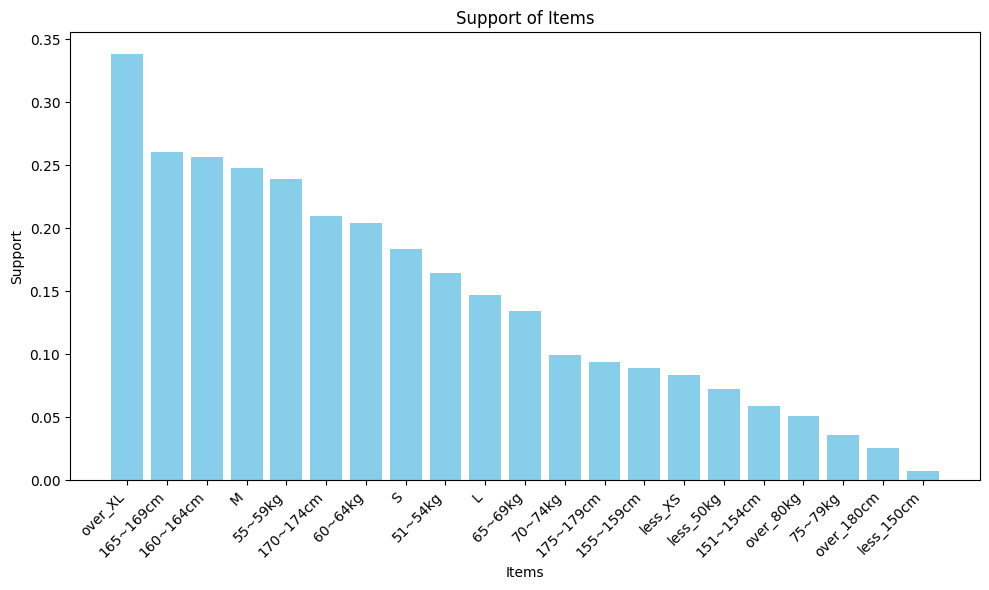

In [49]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt

# Apriori 알고리즘 수행
frequent_itemsets = apriori(encoded_df, min_support=0.01, use_colnames=True)
print("----------------frequent itemsets-----------------")
print(frequent_itemsets)

# 각 항목별 빈도 계산
item_frequencies = encoded_df.sum().sort_values(ascending=False)

# 지지도 계산
total_transactions = len(encoded_df)  # 전체 거래 수
item_supports = item_frequencies / total_transactions  # 지지도 계산

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(item_supports.index, item_supports.values, color='skyblue')
plt.xlabel('Items', fontsize=10)
plt.ylabel('Support', fontsize=10)  # Y축 레이블을 'Support'로 변경
plt.title('Support of Items', fontsize=12)
plt.xticks(rotation=45, ha='right')  # 항목 이름이 길 경우
plt.tight_layout()
plt.show()

In [50]:
frequent_itemsets['num_itemsets'] = len(frequent_itemsets)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.03, num_itemsets = frequent_itemsets['num_itemsets'])
print("-------------------------연관 규칙-------------------------")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

-------------------------연관 규칙-------------------------
              antecedents           consequents   support  confidence  \
0             (151~154cm)             (51~54kg)  0.017587    0.298380   
1               (51~54kg)           (151~154cm)  0.017587    0.107132   
2             (151~154cm)             (55~59kg)  0.011557    0.196078   
3               (55~59kg)           (151~154cm)  0.011557    0.048255   
4                     (M)           (151~154cm)  0.014070    0.056684   
..                    ...                   ...       ...         ...   
341  (over_XL, 175~179cm)             (70~74kg)  0.016004    0.341433   
342  (70~74kg, 175~179cm)             (over_XL)  0.016004    0.858105   
343             (over_XL)  (70~74kg, 175~179cm)  0.016004    0.047259   
344             (70~74kg)  (over_XL, 175~179cm)  0.016004    0.160602   
345           (175~179cm)    (over_XL, 70~74kg)  0.016004    0.170655   

         lift  
0    1.817559  
1    1.817559  
2    0.818678  
3  

In [51]:
print(rules[['antecedents', 'consequents']])

height_to_size_rules = rules[
    (rules['antecedents'].apply(lambda x: any(item.endswith('cm') for item in x))) &
    (rules['consequents'].apply(lambda x: any(item in ['less_XS', 'S', 'M', 'L', 'over_XL'] for item in x)))
]

# Confidence 기준으로 내림차순 정렬
height_to_size_rules = height_to_size_rules.sort_values(by='confidence', ascending=False)

print("-------------------------키 -> 사이즈 연관 규칙-----------------------")
print(height_to_size_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

              antecedents           consequents
0             (151~154cm)             (51~54kg)
1               (51~54kg)           (151~154cm)
2             (151~154cm)             (55~59kg)
3               (55~59kg)           (151~154cm)
4                     (M)           (151~154cm)
..                    ...                   ...
341  (over_XL, 175~179cm)             (70~74kg)
342  (70~74kg, 175~179cm)             (over_XL)
343             (over_XL)  (70~74kg, 175~179cm)
344             (70~74kg)  (over_XL, 175~179cm)
345           (175~179cm)    (over_XL, 70~74kg)

[346 rows x 2 columns]
-------------------------키 -> 사이즈 연관 규칙-----------------------
                antecedents           consequents   support  confidence  \
276  (165~169cm, over_80kg)             (over_XL)  0.012805    0.993502   
330  (over_80kg, 170~174cm)             (over_XL)  0.012663    0.985016   
216    (70~74kg, 160~164cm)             (over_XL)  0.014765    0.918229   
270    (70~74kg, 165~169cm)          

In [52]:
weight_to_size_rules = rules[
    (rules['antecedents'].apply(lambda x: any(item.endswith('kg') for item in x))) &
    (rules['consequents'].apply(lambda x: any(item in ['less_XS', 'S', 'M', 'L', 'over_XL'] for item in x)))
]

# Confidence 기준으로 내림차순 정렬
weight_to_size_rules = weight_to_size_rules.sort_values(by='confidence', ascending=False)

print("-------------------------몸무게 -> 사이즈 규칙-------------------------")
print(weight_to_size_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

-------------------------몸무게 -> 사이즈 규칙-------------------------
                antecedents           consequents   support  confidence  \
276  (165~169cm, over_80kg)             (over_XL)  0.012805    0.993502   
147             (over_80kg)             (over_XL)  0.050484    0.988845   
330  (over_80kg, 170~174cm)             (over_XL)  0.012663    0.985016   
139               (75~79kg)             (over_XL)  0.034136    0.963593   
216    (70~74kg, 160~164cm)             (over_XL)  0.014765    0.918229   
..                      ...                   ...       ...         ...   
290               (55~59kg)        (S, 170~174cm)  0.015602    0.065144   
308               (60~64kg)  (over_XL, 170~174cm)  0.013015    0.063730   
200               (60~64kg)        (M, 160~164cm)  0.012956    0.063443   
127               (60~64kg)                   (S)  0.011859    0.058071   
176               (55~59kg)        (L, 160~164cm)  0.011423    0.047696   

         lift  
276  2.933653  
147

In [53]:
# 키, 몸무게 -> 사이즈 연관 규칙
height_weight_to_size_rules = rules[
    (rules['antecedents'].apply(lambda x: any(item.endswith('cm') or item.endswith('kg') for item in x))) &  # 키와 몸무게 관련 항목
    (rules['consequents'].apply(lambda x: any(item in ['less_XS', 'S', 'M', 'L', 'over_XL'] for item in x)))  # 사이즈 관련 항목
]

height_weight_to_size_rules = height_weight_to_size_rules.sort_values(by='confidence', ascending=False)

print("------------------------- (키, 몸무게) -> 사이즈 규칙-------------------------")
print(height_weight_to_size_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

------------------------- (키, 몸무게) -> 사이즈 규칙-------------------------
                antecedents           consequents   support  confidence  \
276  (165~169cm, over_80kg)             (over_XL)  0.012805    0.993502   
147             (over_80kg)             (over_XL)  0.050484    0.988845   
330  (over_80kg, 170~174cm)             (over_XL)  0.012663    0.985016   
139               (75~79kg)             (over_XL)  0.034136    0.963593   
216    (70~74kg, 160~164cm)             (over_XL)  0.014765    0.918229   
..                      ...                   ...       ...         ...   
315             (170~174cm)          (L, 65~69kg)  0.010502    0.050168   
225             (160~164cm)  (less_50kg, less_XS)  0.012629    0.049284   
278             (165~169cm)  (over_XL, over_80kg)  0.012805    0.049140   
176               (55~59kg)        (L, 160~164cm)  0.011423    0.047696   
177             (160~164cm)          (L, 55~59kg)  0.011423    0.044578   

         lift  
276  2.933653

In [54]:
height_mapping = {
    'less_150cm': (0, 150),
    '151~154cm': (151, 154),
    '155~159cm': (155, 159),
    '160~164cm': (160, 164),
    '165~169cm': (165, 169),
    '170~174cm': (170, 174),
    '175~179cm': (175, 179),
    'over_180cm': (180, float('inf'))
}
weight_mapping = {
    'less_50kg': (0, 50),
    '51~54kg': (51, 54),
    '55~59kg': (55, 59),
    '60~64kg': (60, 64),
    '65~69kg': (65, 69),
    '70~74kg': (70, 74),
    '75~79kg': (75, 79),
    'over_80kg': (80, float('inf'))
}
size_mapping = {
    'less_XS': 'XS이하',
    'S': 'S',
    'M': 'M',
    'L': 'L',
    'over_XL': 'XL이상'
}

In [57]:
def extract_ranges(antecedents):
    min_height, max_height, min_weight, max_weight = None, None, None, None

    for item in antecedents:
        if item.endswith('cm'):
            height_range = height_mapping.get(item)
            if height_range:
                min_height, max_height = height_range
        elif item.endswith('kg'):
            weight_range = weight_mapping.get(item)
            if weight_range:
                min_weight, max_weight = weight_range

    return min_height, max_height, min_weight, max_weight

# 각 사이즈를 개별적으로 처리
expanded_rows = []

for _, row in height_weight_to_size_rules.iterrows():
    antecedents = row['antecedents']
    consequents = row['consequents']
    confidence = row['confidence']
    min_height, max_height, min_weight, max_weight = extract_ranges(antecedents)

    for size in consequents:
        size_korean = size_mapping.get(size, size)  # size를 매핑
        expanded_rows.append({
            'min_height': min_height,
            'max_height': max_height,
            'min_weight': min_weight,
            'max_weight': max_weight,
            'size': size_korean,
            'confidence': confidence
        })

# DataFrame으로 변환
expanded_df = pd.DataFrame(expanded_rows)

# CSV로 저장
result_file_path = 'apriori_result.csv'
expanded_df.to_csv(result_file_path, index=False)

In [58]:
from google.colab import files
files.download(result_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>